# Ataques Adversariais: Comprometendo Sistemas Baseados em Machine Learning

O treinamento do modelo tem o objetivo detectar se uma mão humana saudável está aberta ou fechada.

## Importações

In [1]:
# Import libraries
import numpy as np
from PIL import Image, ImageOps  # Install pillow instead of PIL
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

# Import tensorflow and keras libraries
import tensorflow as tf
from keras.models import load_model  # TensorFlow is required for Keras to work

## Funções Úteis

In [2]:
# Preprocess image so that it can be inputted to MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Load and preprocess image
def loadAndPreprocessImage(image_path):
  image = Image.open(image_path)
  image = image.convert("RGB")
  image = preprocess(image)
  return image

# Print image and its class and score if they exist
def printImage(image, class_name=None, confidence_score=None, eps=None):
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
  if((class_name == None) and (eps != None)):
    plt.title('Epsilon: {:0.3f}'.format(eps))
  elif((class_name != None) and (eps == None)):
    plt.title('Classe: {} Confiança: {}'.format(class_name, confidence_score))
  elif((class_name != None) and (eps != None)):
    plt.title('Epsilon: {:0.3f}\nClasse: {} Confiança: {}'.format(eps, class_name, confidence_score))
  plt.show()

# Classify sample using a pretrained model
def classifySample(image, pretrained_model):
  image_probs = pretrained_model.predict(image)
  index = np.argmax(image_probs)
  class_name = decode_predictions[index]
  confidence_score = image_probs[0][index]
  return image_probs, class_name, confidence_score

## Mostrando as imagens

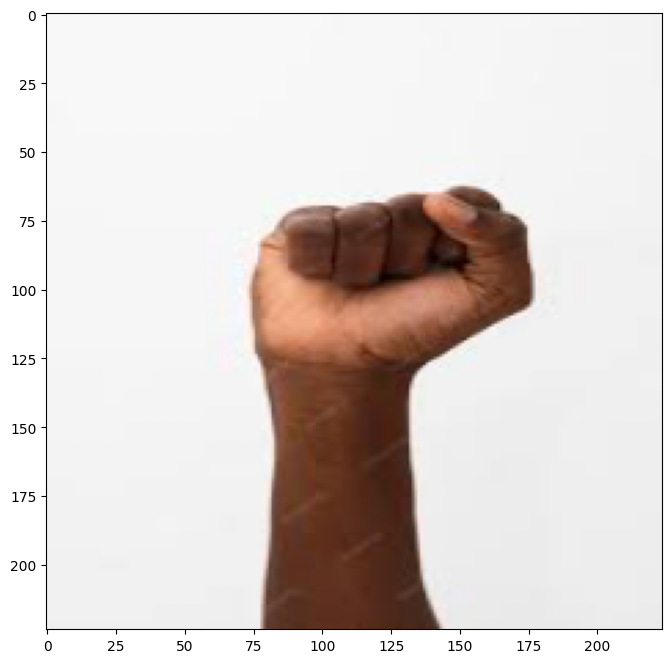

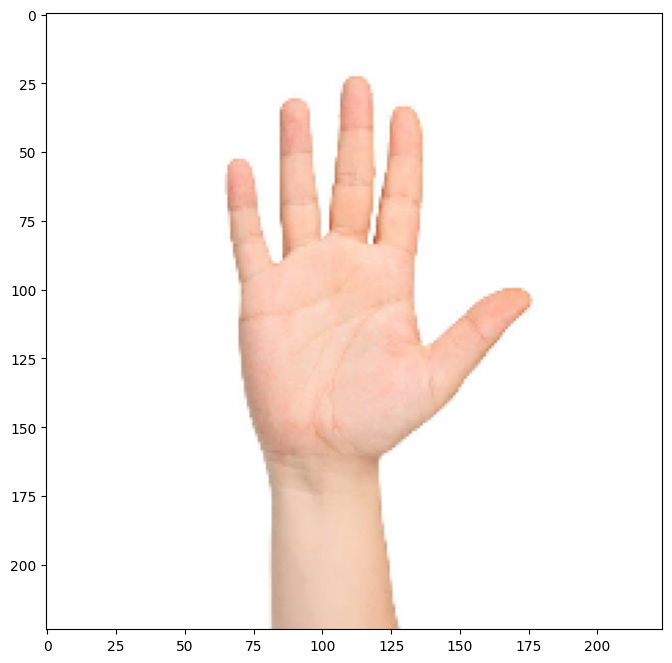

In [3]:
# Load and preprocess sample image
image1 = loadAndPreprocessImage('../../../Dados/imagem01.png')
image2 = loadAndPreprocessImage('../../../Dados/imagem02.png')
printImage(image1)
printImage(image2)

As listras na imagem da mão negra são defeitos da imagem em si, não perturbações.

## Carregando o modelo

In [4]:
# Load pretrained classifier
pretrained_model = load_model("../../Dados/keras_model.h5", compile=False)
pretrained_model.trainable = False
decode_predictions = open("../../Dados/labels.txt", "r").readlines()

## Realizando a inferência

1/1 [==============================] - 3s 3s/step


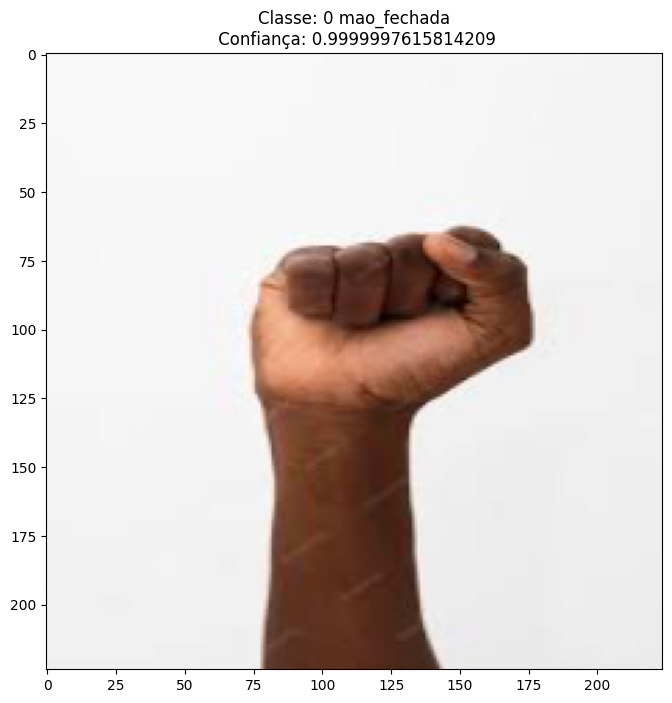

1/1 [==============================] - 0s 78ms/step


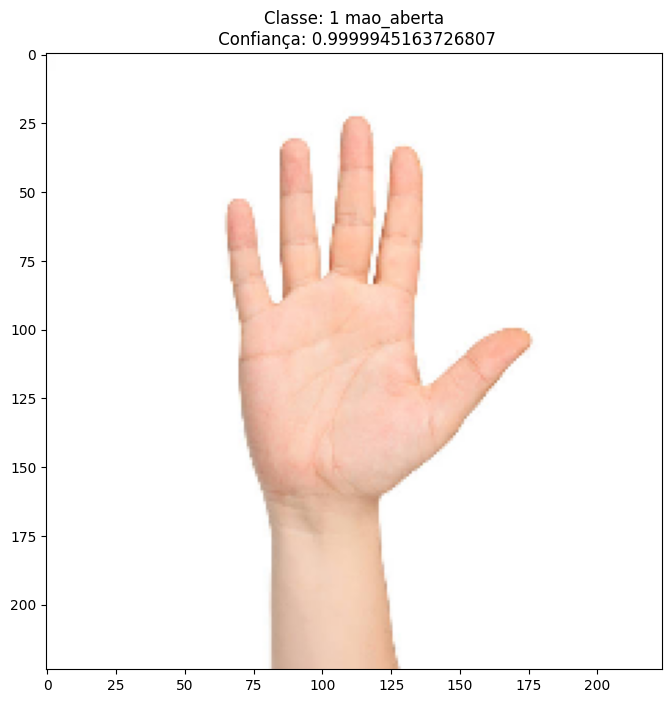

In [5]:
# Classify sample image and print classification result
image_probs, class_name, confidence_score = classifySample(image1, pretrained_model)
# print(image_probs)
printImage(image1, class_name, confidence_score)

image_probs, class_name, confidence_score = classifySample(image2, pretrained_model)
# print(image_probs)
printImage(image2, class_name, confidence_score)

# Ataques Iterativos - WhiteBox
## Bem-vindo ao CleverHans!

https://github.com/cleverhans-lab/cleverhans

## Instalando a biblioteca

In [6]:
! pip install cleverhans

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.2 MB/s eta 0:00:00


## BIM

### Importando o ataque iterativo

In [7]:
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method

### Gerando o Exemplo Adversarial

In [13]:
# Craft adversarial sample
adversarial_sample = basic_iterative_method(pretrained_model, image1, 0.5, 0.01, 40, np.inf)

### Realizando a classificação do exemplo adversarial

1/1 [==============================] - 0s 37ms/step


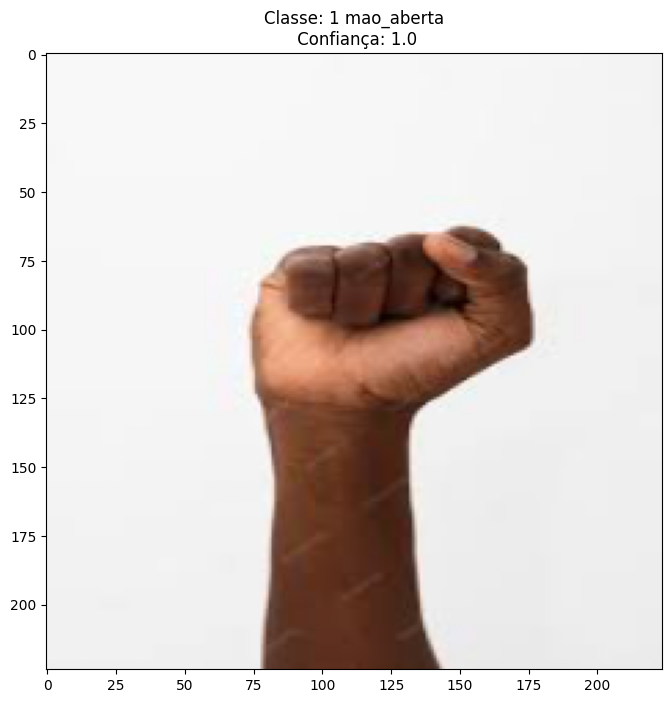

In [14]:
# Classify adversarial sample and print classification result
image_probs, class_name, confidence_score = classifySample(adversarial_sample, pretrained_model)
printImage(image1, class_name, confidence_score)

### Exibindo uma aproximação da perturbação

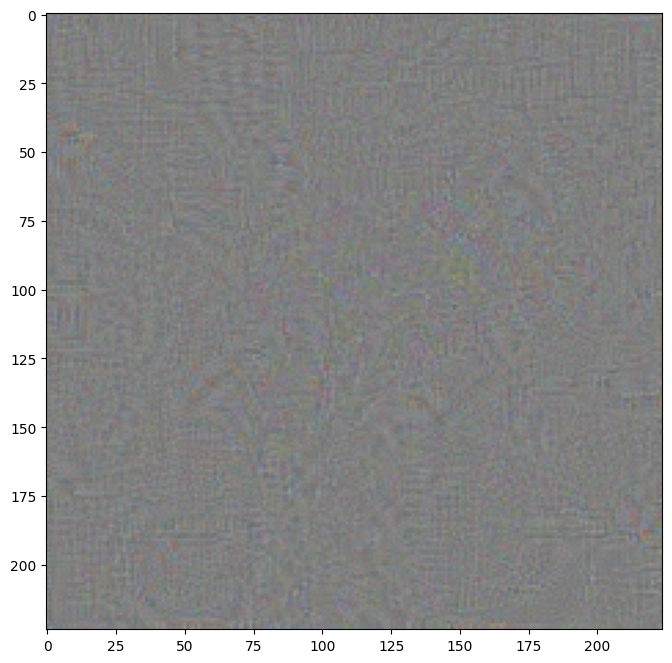

In [10]:
# Get and print adversarial perturbation
adversarial_perturbation = (adversarial_sample - image1) # o clip é dado após somar clean_sample+e*adv_perturbation, não tem como desfazê-lo para obter o adv_perturbation, sendo o adversarial perturbation uma aproximação.
printImage(adversarial_perturbation)

## PGD

In [15]:
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

Primeiro, tentei usar uma abordagem de testes que eu usei durante a atividade de clustering, usando vários **for** para testar vários valores de parâmetros, porém, não foi eficiente, primeiro porque o PGD é lento, e segundo porque não consegui rodar no meu computador, e o colab é muito mais lento.

In [ ]:
eps_list = np.arange(0.1, 0.5, 0.1)
eps_iter_list = np.arange(0.001, 0.01, 0.002)
nb_iter_list = np.arange(10, 70, 15)

confidence_score = 0
best = [0,0,0,0,0,0]

for eps in eps_list:
  for eps_iter in eps_iter_list:
    for nb_iter in nb_iter_list:
      adversarial_sample_2_0 = projected_gradient_descent(pretrained_model, image1, eps, eps_iter, nb_iter, np.inf)
      image_probs, class_name, confidence_score = classifySample(adversarial_sample_2_0, pretrained_model)

      if confidence_score > best[2]:
        best = (image_probs, class_name, confidence_score, eps, eps_iter, nb_iter)

best[0], best[0], best[0] = classifySample(adversarial_sample_2_0, pretrained_model)
printImage(image1, best[1], best[2])

Tentei fazer primeiro uma abordagem que usasse poucas iterações(2), pra ser um mais rápido, e obtive um bom resultado com estes parâmetros:

EPS: 0.005

EPS/ITER: 0.0025

N_ITER: **2**

In [120]:
# Craft adversarial sample
adversarial_sample_2_0 = projected_gradient_descent(pretrained_model, image1, 0.005, 0.0025, 2, np.inf)
adversarial_sample_2_1 = projected_gradient_descent(pretrained_model, image2, 0.005, 0.0025, 2, np.inf)

1/1 [==============================] - 0s 33ms/step


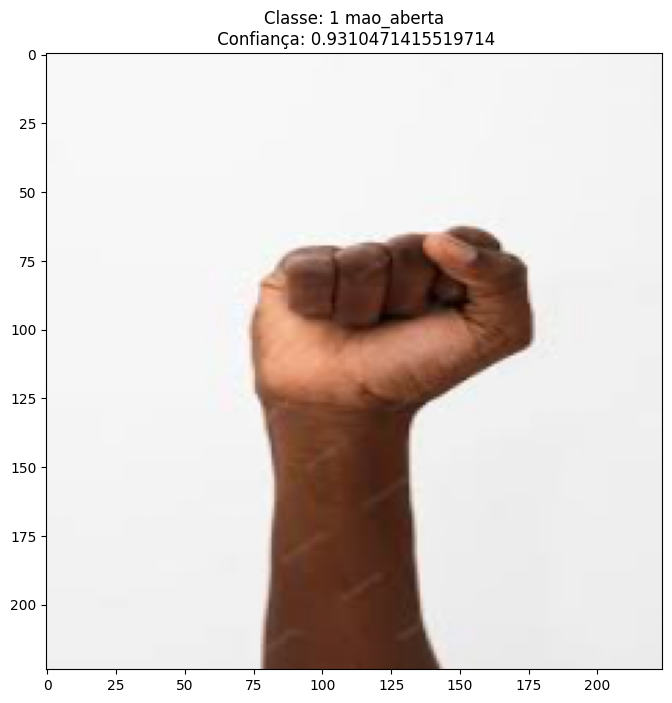

1/1 [==============================] - 0s 38ms/step


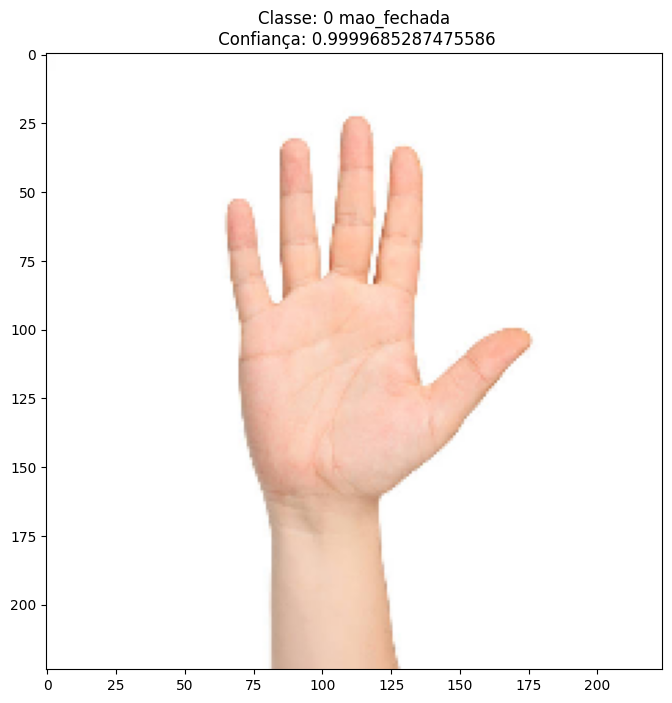

In [121]:
# Classify adversarial sample and print classification result
image_probs, class_name, confidence_score = classifySample(adversarial_sample_2_0, pretrained_model)
printImage(image1, class_name, confidence_score)
image_probs, class_name, confidence_score = classifySample(adversarial_sample_2_1, pretrained_model)
printImage(image2, class_name, confidence_score)

As perturbações podem ser claramente confundidas com má qualidade de imagem, então considero o ataque como um sucesso, pelo menos considerando análises a olho nu humano.

Agora, uma abordagem que foca em usar as menores perturbações possíveis. Obtendo um resultado igual a:

EPS: 0.0025

EPS/ITER: 0.00005

N_ITER: **300**

O EPS se tornou 25% do EPS da versão rápida, o EPS/ITER se tornou 5% comparado com a configuração rápida, e o número de iretações (N_ITER) se tornou 60 vezes maior, ou seja, 300(apesar de que com 100 também resultou em um resultado satisfatório).

In [86]:
# Craft adversarial sample
adversarial_sample_2_0 = projected_gradient_descent(pretrained_model, image1, 0.0025, 0.00005, 300, np.inf)
adversarial_sample_2_1 = projected_gradient_descent(pretrained_model, image2, 0.0025, 0.00005, 300, np.inf)

1/1 [==============================] - 0s 35ms/step


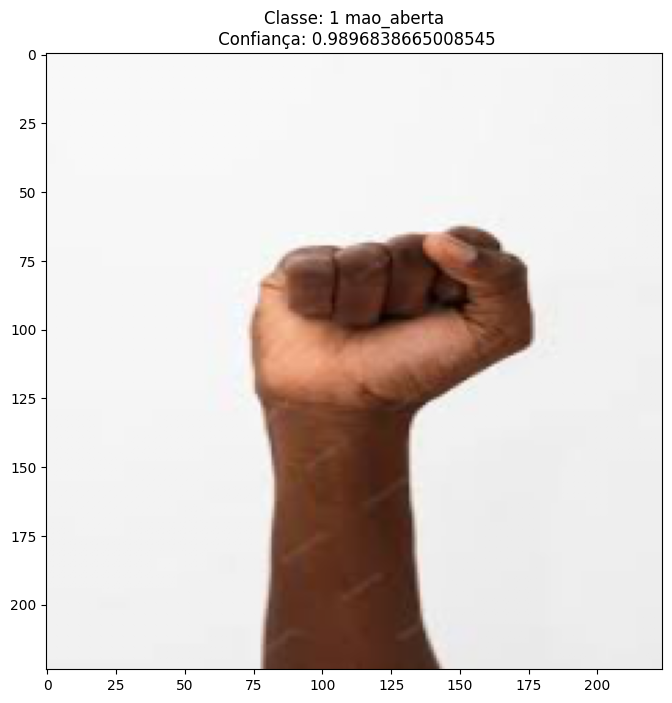

1/1 [==============================] - 0s 52ms/step


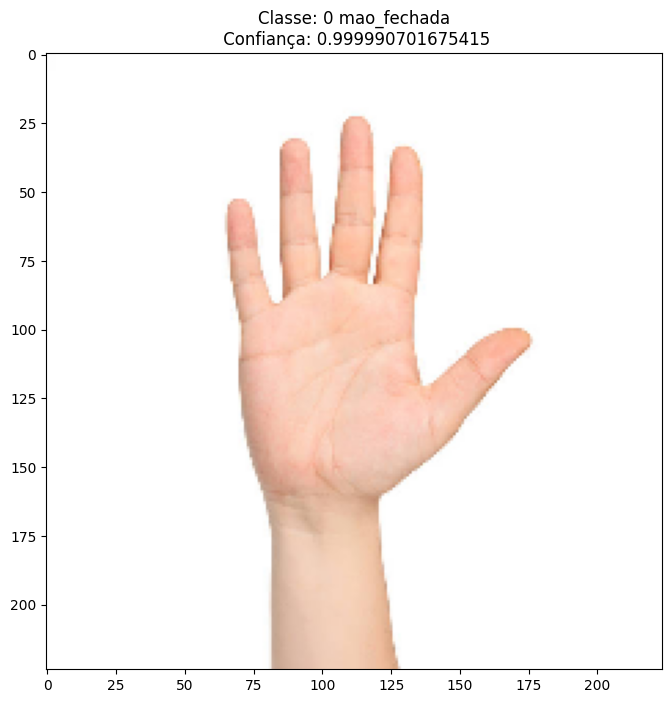

In [87]:
# Classify adversarial sample and print classification result
image_probs, class_name, confidence_score = classifySample(adversarial_sample_2_0, pretrained_model)
printImage(image1, class_name, confidence_score)
image_probs, class_name, confidence_score = classifySample(adversarial_sample_2_1, pretrained_model)
printImage(image2, class_name, confidence_score)

## MIM

In [16]:
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method

Primeiramente, na abordagem com número de iterações baixo, o resultado foi bem próximo ao do GPD, mas um pouco inferior, principalmente por causa da imagem **imagem01**. Os parâmetros foram:

EPS: 0.01

EPS/ITER: 0.0025

N_ITER: **2**

In [122]:
# Craft adversarial sample
adversarial_sample_3_0 = momentum_iterative_method(pretrained_model, image1, 0.005, 0.0025, 2, np.inf)
adversarial_sample_3_1 = momentum_iterative_method(pretrained_model, image2, 0.005, 0.0025, 2, np.inf)

1/1 [==============================] - 0s 59ms/step


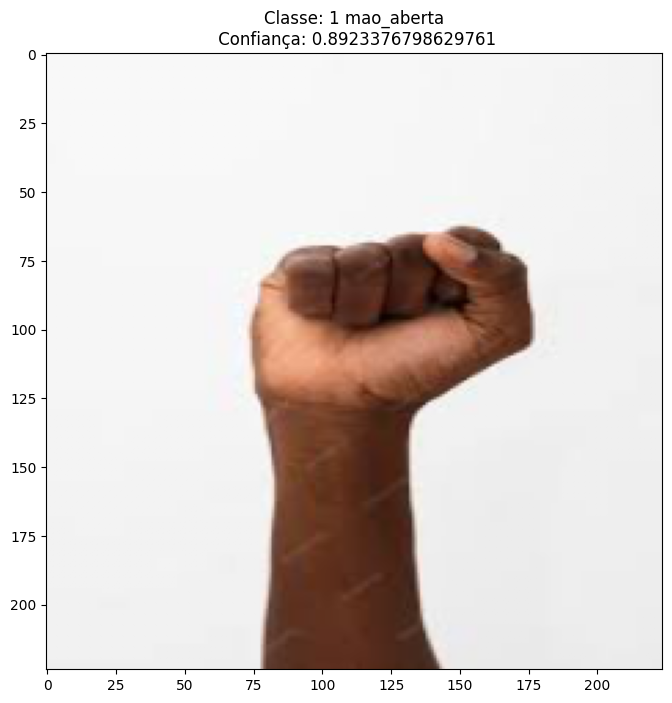

1/1 [==============================] - 0s 38ms/step


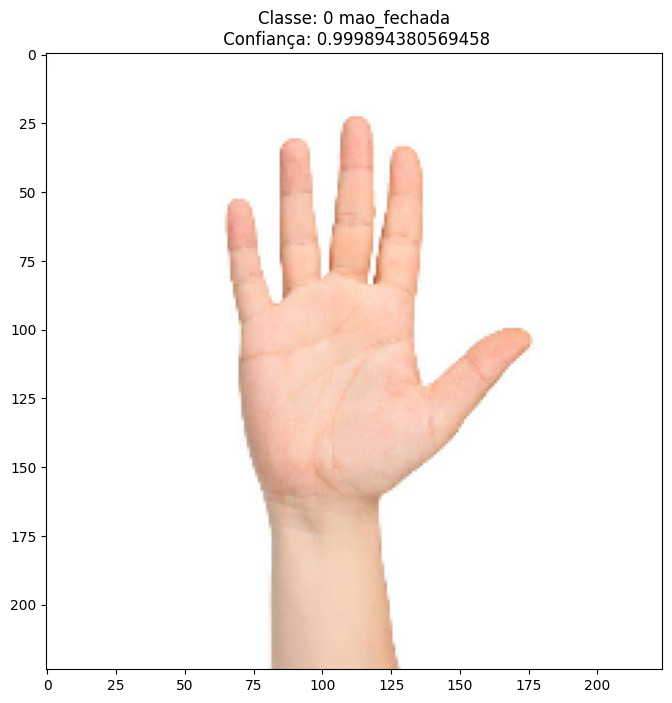

In [123]:
# Classify adversarial sample and print classification result
image_probs, class_name, confidence_score = classifySample(adversarial_sample_3_0, pretrained_model)
printImage(image1, class_name, confidence_score)
image_probs, class_name, confidence_score = classifySample(adversarial_sample_3_1, pretrained_model)
printImage(image2, class_name, confidence_score)

Como o ruído foi configurado da mesma forma, é de se esperar que o resultado visual seja parecido com o do GPD, pois aqui também não há indícios muito fortes de perturbação na imagem, pois pode ser facilmente confundido com má qualidade de imagem, assim como foi no GPD.

Agora, partindo pra uma menor taxa de perturbação, com os parâmetros:

EPS: 0.0025

EPS/ITER: 0.00005

N_ITER: **300**

In [133]:
# Craft adversarial sample
adversarial_sample_3_0 = momentum_iterative_method(pretrained_model, image1, 0.0025, 0.00005, 300, np.inf)
adversarial_sample_3_1 = momentum_iterative_method(pretrained_model, image2, 0.0025, 0.00005, 300, np.inf)

1/1 [==============================] - 0s 36ms/step


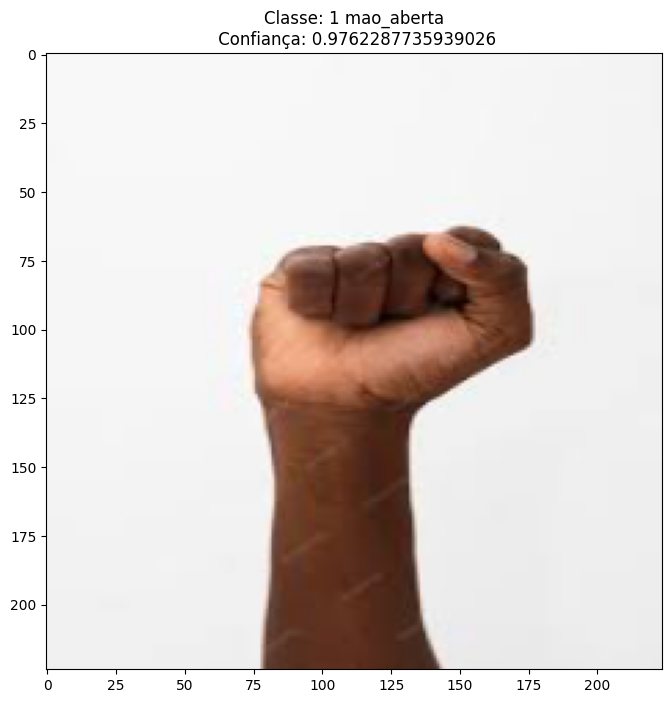

1/1 [==============================] - 0s 35ms/step


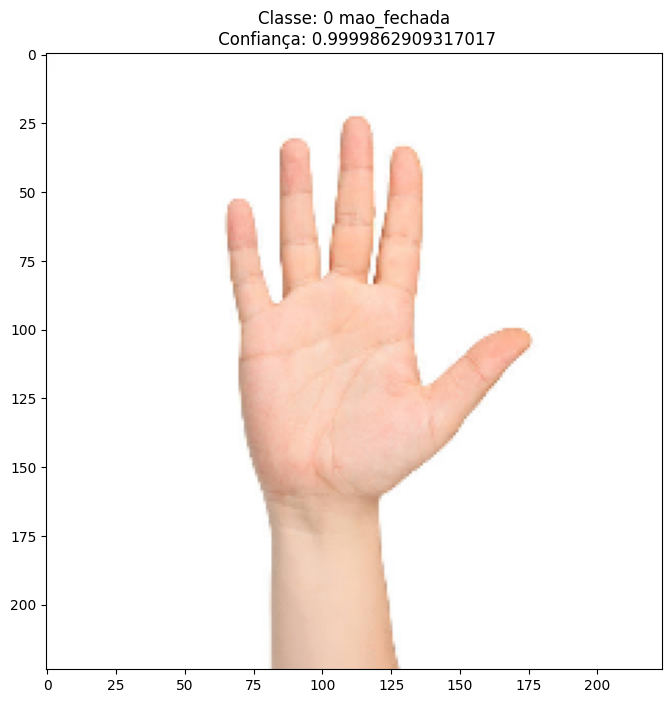

In [134]:
# Classify adversarial sample and print classification result
image_probs, class_name, confidence_score = classifySample(adversarial_sample_3_0, pretrained_model)
printImage(image1, class_name, confidence_score)
image_probs, class_name, confidence_score = classifySample(adversarial_sample_3_1, pretrained_model)
printImage(image2, class_name, confidence_score)

O resultado foi um pouco pior do que o GPD, mas ainda sim satisfatório, sem percepção nítida de manipulação maliciosa.

# Considerações Finais

Inicialmente, meu plano era testar várias combinações de parâmetros dos modelos utilizando vários **for**, mas isso seria muito ineficiente computacionalmente falando, além do Colab ser lento.

Ao testar os modelos, sempre que a prioridade era o baixo número de iterações, eu tentava minimizar o número de iterações, porém, ao chegar no número 2 que considero muito baixo, tentei começar a minimizar as perturbações, porque eram as únicas coisas que sobrou para minimizar, para melhorar os resultados.

Já quando a prioridade eram diminuir o máximo a perturbação, eu tentava deixar a quantidade de perturbação a menor possível, porém eu não poderia simplesmente maximizar o número de iterações, por limitação computacional, então, eu tentei encontrar um número de iterações que fosse grande o suficiente para não fazer tanta diferença no resultado o aumento da mesma, após isso, foquei na minimização das perturbações.

Em todos os testes, obtive um bom resultado a olho nu. Utilizei os mesmos parâmetros para os dois modelos(em cada situação) para poder compara-los, porém, eu também testei outros valores, e dificilmente o resultado dos modelos se distanciavam, e sempre que acontecia era um valor mínimo.